In [1]:
import numpy as np

import random
import h5py
from keras.models import *
from keras.layers import *
from keras.layers.core import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
from keras.regularizers import *
from keras.constraints import *
from keras.losses import *
import scipy.io.wavfile as sciwav
from keras.activations import softmax

import os
import random
import time
import matplotlib
import matplotlib.pyplot as plt

import scipy.signal as sig
import operator
import math
import re

# for reproducibility
np.random.seed(1337) 
random.seed(1337)

Using TensorFlow backend.


In [2]:
from nn_blocks import *
from perceptual_loss import *
from consts import *
from load_data import *
from pesq import *

In [3]:
train_X = np.load('./pesq_dataset/train_X.npy')
train_y = np.load('./pesq_dataset/train_y.npy')

In [4]:
train_X = np.reshape(train_X, (2, -1, WINDOW_SIZE, 1))
train_X = [train_X[0], train_X[1]]

In [5]:
# select a bunch of random rows to evaluate metrics
rows = np.random.randint(train_X[0].shape[0], size = 2048)

In [6]:
clean = train_X[0][rows]
dirty = train_X[1][rows]
labels = train_y[rows]

In [74]:
FFT_SIZE = 512

# multi-scale MFCC distance
MEL_SCALES = [8, 16, 32, 64, 128]

# precompute Mel filterbank: [FFT_SIZE x NUM_MFCC_COEFFS]
MEL_FILTERBANKS = []
for scale in MEL_SCALES:
    filterbank_npy = melFilterBank(scale, FFT_SIZE).transpose()
    MEL_FILTERBANKS.append(K.constant(filterbank_npy))
    
# we precompute matrices for MFCC calculation
DFT_REAL, DFT_IMAG = generate_real_dft_mats(WINDOW_SIZE, FFT_SIZE)

# given a (symbolic Theano) array of size M x WINDOW_SIZE
#     this returns an array M x N where each window has been replaced
#     by some perceptual transform (in this case, MFCC coeffs)
def perceptual_transform(x):
    powerSpectrum = K.square(keras_dft_mag(x, DFT_REAL, DFT_IMAG))
    powerSpectrum = 1.0 / FFT_SIZE * powerSpectrum
    
    logMelTransforms = []
    for filterbank in MEL_FILTERBANKS:
        filteredSpectrum = K.dot(powerSpectrum, filterbank)
        logSpectrum = K.log(filteredSpectrum + K.epsilon())
        logMelTransforms.append(logSpectrum)

    return logMelTransforms
    
# perceptual loss function
def perceptual_distance(y_true, y_pred):
    y_true = K.reshape(y_true, (-1, WINDOW_SIZE))
    y_pred = K.reshape(y_pred, (-1, WINDOW_SIZE))
    
    pvec_true = perceptual_transform(y_true)
    pvec_pred = perceptual_transform(y_pred)
    
    distances = []
    for i in xrange(0, len(MEL_SCALES)):
        error = K.expand_dims(rmse(pvec_pred[i], pvec_true[i]))
        distances.append(error)
    distances = K.concatenate(distances, axis = -1)

    loss = K.mean(distances, axis = -1)   
    return loss

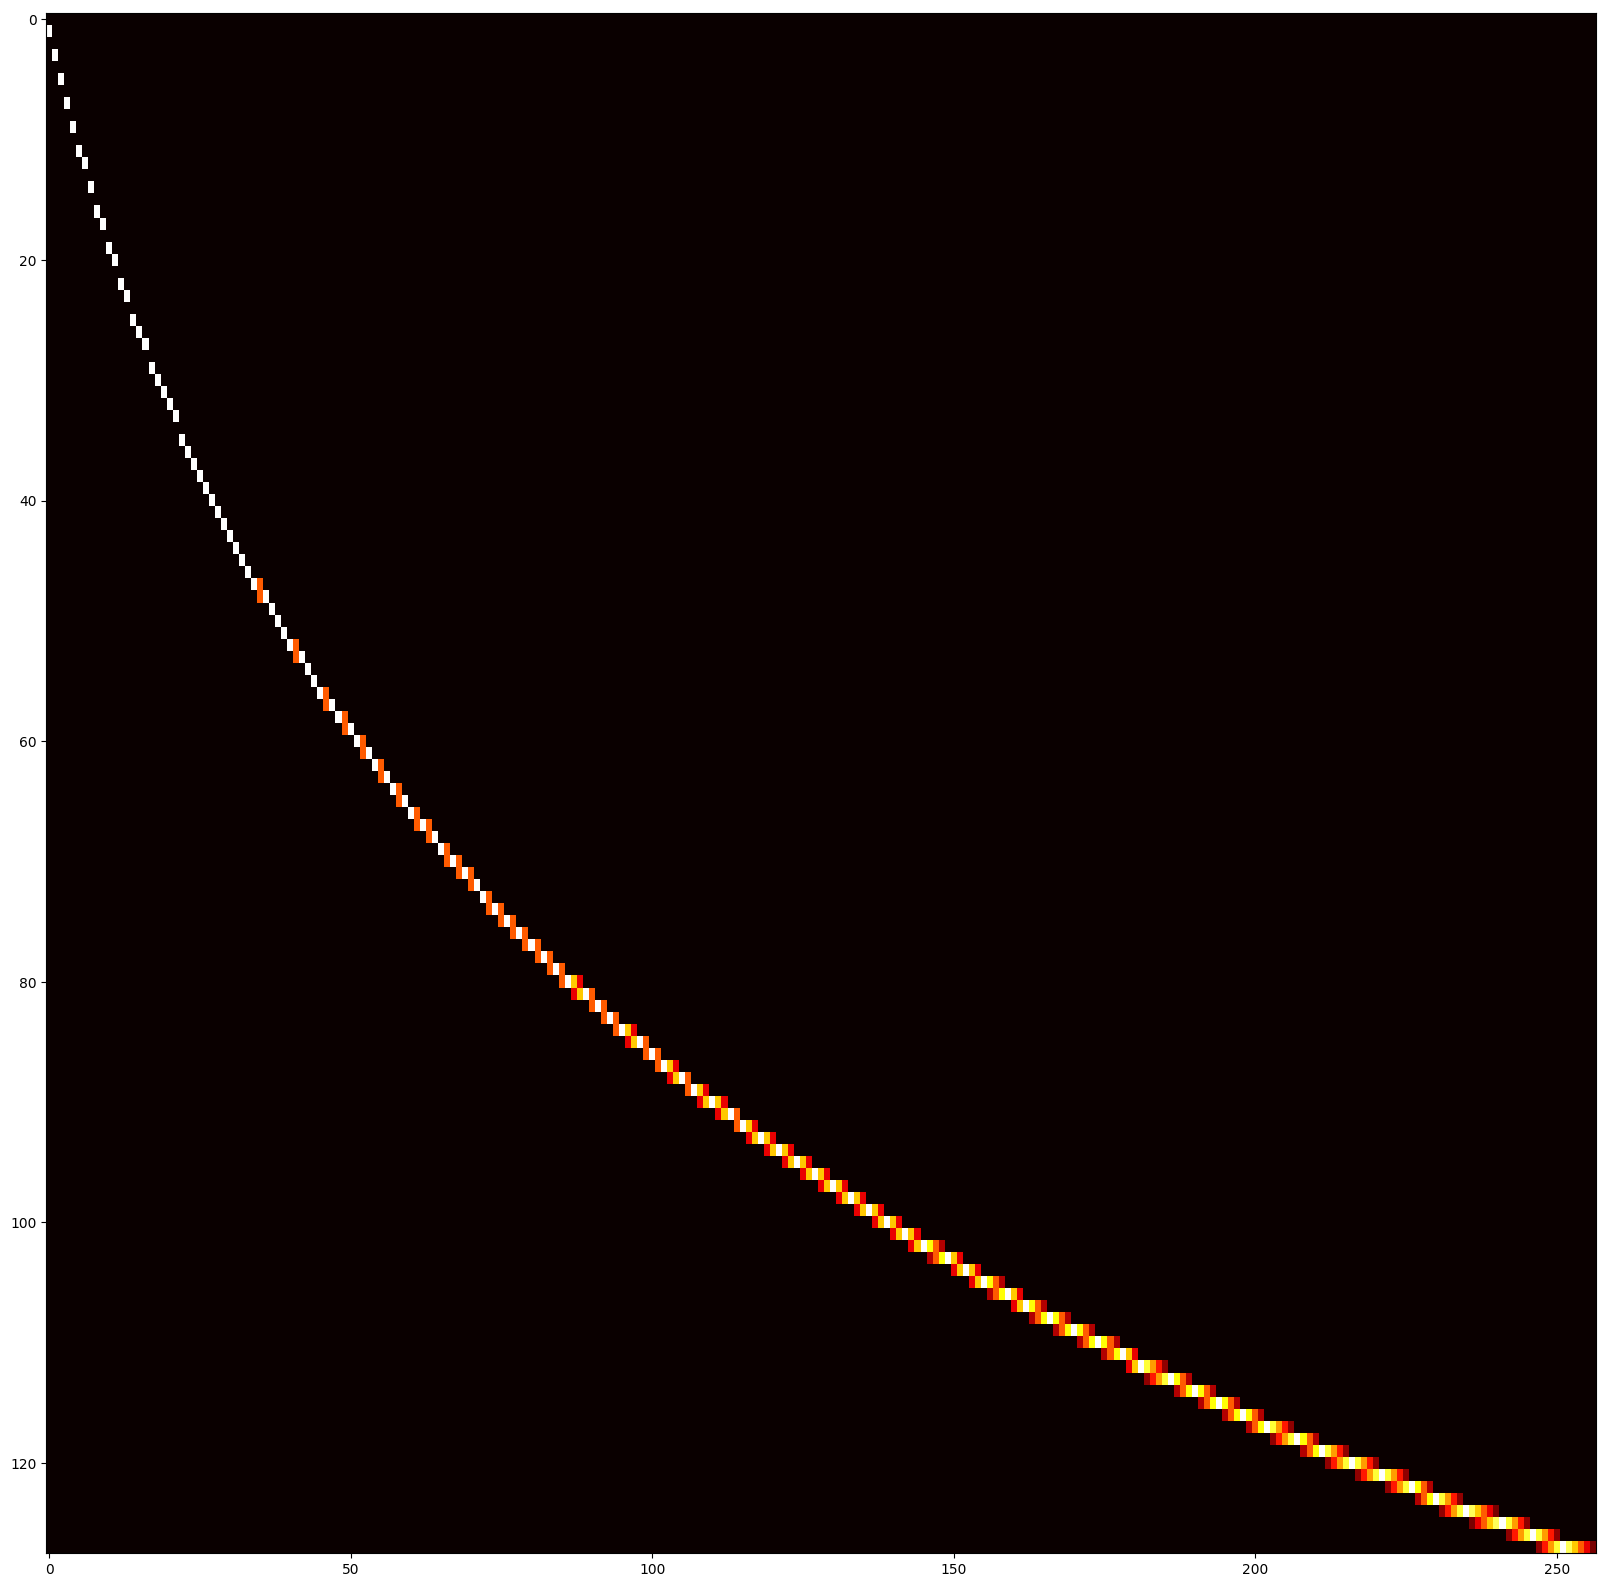

In [75]:
plt.figure(figsize = (20, 20))
plt.imshow(K.eval(MEL_FILTERBANKS[-1]).transpose(), cmap='hot', interpolation='nearest', aspect = 'auto')
plt.show()

In [76]:
def l1_dist(x, y):
    return np.mean(np.abs(x - y), axis = 1).flatten()

l1_dist_baseline = l1_dist(clean, dirty)
mean = np.mean(l1_dist_baseline)
std = np.std(l1_dist_baseline)
print mean, std
print np.corrcoef(l1_dist_baseline, labels)[1, 0]

0.00836700701092 0.0179676914569
-0.296058657756


In [77]:
def l2_dist(x, y):
    return np.sqrt(np.mean(np.square(x - y), axis = 1).flatten())

l2_dist_baseline = l2_dist(clean, dirty)
mean = np.mean(l2_dist_baseline)
std = np.std(l2_dist_baseline)
print mean, std
print np.corrcoef(l2_dist_baseline, labels)[1, 0]

0.0103892411821 0.0215766140767
-0.304893666714


In [78]:
def lifter(cepstra, L=22):
    """Apply a cepstral lifter the the matrix of cepstra. This has the effect of increasing the
    magnitude of the high frequency DCT coeffs.
    
    :param cepstra: the matrix of mel-cepstra, will be numframes * numcep in size.
    :param L: the liftering coefficient to use. Default is 22. L <= 0 disables lifter.
    """
    if L > 0:
        nframes,ncoeff = numpy.shape(cepstra)
        n = numpy.arange(ncoeff)
        lift = 1 + (L/2.)*numpy.sin(numpy.pi*n/L)
        return lift*cepstra
    else:
        # values of L <= 0, do nothing
        return cepstra

In [79]:
# BASELINE: MFCC vector distance
mfcc_dist_baseline = K.eval(perceptual_distance(clean.astype('float32'), dirty.astype('float32')))
mean = np.mean(mfcc_dist_baseline)
std = np.std(mfcc_dist_baseline)
print mean, std
print np.corrcoef(mfcc_dist_baseline, labels)[1, 0]

0.680833 1.1392
-0.527582729635


In [80]:
print np.corrcoef(mfcc_dist_baseline, l1_dist_baseline)[1, 0]

0.0894483392226


In [81]:
train_X[0].shape

(124425, 512, 1)

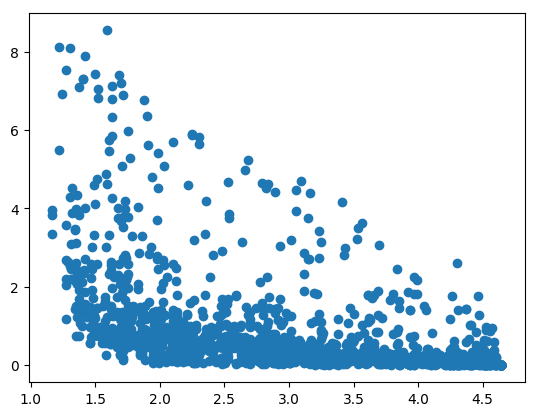

In [82]:
sorted_idxs = train_y[rows].argsort()
sorted_idxs = sorted_idxs[mfcc_dist_baseline[sorted_idxs] > 0]

x = train_y[rows][sorted_idxs]
y = mfcc_dist_baseline[sorted_idxs]

plt.scatter(x, y)
plt.show()

In [83]:
# combined distance
combined_baseline = 30.0 * l2_dist_baseline + 5.0 * mfcc_dist_baseline
mean = np.mean(combined_baseline)
std = np.std(combined_baseline)
print mean, std
print np.corrcoef(combined_baseline, labels)[1, 0]

3.71584285284 5.79166165738
-0.552944976901


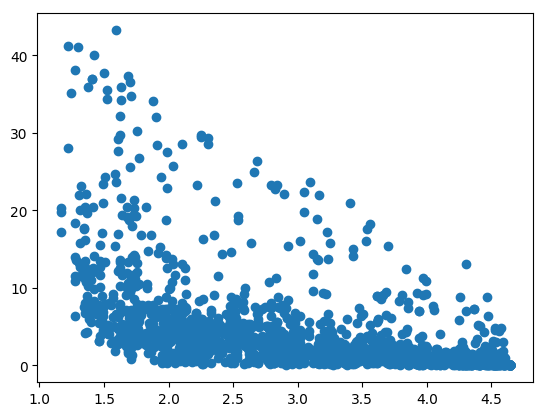

In [84]:
sorted_idxs = train_y[rows].argsort()
sorted_idxs = sorted_idxs[combined_baseline[sorted_idxs] > 0]

x = train_y[rows][sorted_idxs]
y = combined_baseline[sorted_idxs]

plt.scatter(x, y)
plt.show()